In [39]:
from __future__ import annotations

import importlib
import pathlib

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import polars
import theme
from plotly.subplots import make_subplots

polars.Config.set_tbl_rows(100)

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [40]:
def load_data(directory):
    data = polars.read_csv(pathlib.Path(directory) / 'results.csv')

    data = data.with_columns(
        (polars.col('workflow_makespan_ms') / 1000).alias(
            'workflow_makespan_s',
        ),
    )
    data = data.with_columns(
        polars.when(
            polars.col('submission_method').str.starts_with('sequential'),
        )
        .then(polars.col('task_sleep') * polars.col('task_chain_length'))
        .otherwise(
            (1 - polars.col('task_overhead_fraction'))
            * polars.col('task_sleep')
            * polars.col('task_chain_length'),
        )
        .alias('limit'),
    )

    return data

In [41]:
def create_trend_figure(data, layout=None):
    fig = go.Figure()

    data = data.select(
        polars.col('submission_method'),
        polars.col('task_overhead_fraction'),
        polars.col('workflow_makespan_s'),
        polars.col('limit'),
    )
    data = data.group_by('submission_method', 'task_overhead_fraction').agg(
        [
            polars.col('limit').mean(),
            polars.col('workflow_makespan_s')
            .mean()
            .alias('workflow_makespan_s_mean'),
            polars.col('workflow_makespan_s')
            .std()
            .alias('workflow_makespan_s_std'),
        ],
    )

    labels = {
        'sequential-no-proxy': 'Seq. (No Proxy)',
        'sequential-proxy': 'Seq. (Proxy)',
        'pipelined-proxy-future': 'Pipe. (ProxyFuture)',
    }
    colors = {
        'sequential-no-proxy': px.colors.qualitative.Bold[1],
        'sequential-proxy': px.colors.qualitative.Bold[1],
        'pipelined-proxy-future': px.colors.qualitative.Bold[0],
    }
    markers = ('circle', 'square', 'diamond')

    for i, deployment in enumerate(labels.keys()):
        subdata = data.filter(
            polars.col('submission_method') == deployment.lower(),
        )
        if len(subdata) == 0:
            continue

        scatter_data = go.Scatter(
            x=subdata['task_overhead_fraction'],
            y=subdata['workflow_makespan_s_mean'],
            error_y=dict(
                type='data',
                array=subdata['workflow_makespan_s_std'],
                visible=True,
            ),
            name=labels[deployment],
            line=dict(color=colors[deployment]),
            mode='lines+markers',
            marker=dict(symbol=markers[i], size=10),
        )
        fig.add_trace(scatter_data)

        if deployment == 'sequential-proxy':
            scatter_limit = go.Scatter(
                x=subdata['task_overhead_fraction'],
                y=subdata['limit'],
                name='Sequential Limit',
                line=dict(color=colors[deployment], dash='dash'),
                mode='lines',
            )
            fig.add_trace(scatter_limit)
        elif deployment == 'pipelined-proxy-future':
            scatter_limit = go.Scatter(
                x=subdata['task_overhead_fraction'],
                y=subdata['limit'],
                name='Pipelined Limit',
                line=dict(color=colors[deployment], dash='dash'),
                mode='lines',
            )
            fig.add_trace(scatter_limit)

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Task Pipelining with Futures'},
        xaxis_title='Task Overhead Fraction',
        yaxis_title='Makespan (s)',
        yaxis={'tickformat': '.0f'},
        # For transparency: bgcolor = 'rgba(255,255,255,0.2)'
        legend=dict(
            yanchor='top',
            y=0.99,
            xanchor='right',
            x=0.995,
            tracegroupgap=2,
        ),
        template='proxystore',
        **layout,
    )

    return fig

In [88]:
def extract_timestamps(data, sections):
    assert len(data) == 1

    timestamps = data['task_timestamps'].item()
    timestamps = timestamps.split(':')
    timestamps = [sorted(float(x) for x in t.split('-')) for t in timestamps]
    timestamps = sorted(timestamps, key=lambda x: x[0])

    start_timestamp = timestamps[0][0]
    timestamps = [[v - start_timestamp for v in t] for t in timestamps]

    parts = []
    for task_index, timestamp in enumerate(timestamps):
        assert len(timestamp) == len(sections) + 1
        for i, section in enumerate(sections):
            start = timestamp[i]
            end = timestamp[i + 1]
            part = dict(
                Task=task_index % 3,
                Start=start,
                Finish=end,
                delta=end - start,
                section=section,
            )
            parts.append(part)

    return parts  # polars.DataFrame(parts)


def create_timeline_figure(data, layout=None):
    sections = (
        'submit',
        'overhead',
        'resolve',
        'compute',
        'generate',
        'receive',
    )
    sample_types = (
        ('sequential-no-proxy', 0.2, 'Sequential<br>No Proxy'),
        ('sequential-proxy', 0.2, 'Sequential<br>Proxy'),
        ('pipelined-proxy-future', 0.2, 'Pipelined<br>ProxyFuture'),
        ('pipelined-proxy-future', 0.5, 'Pipelined<br>ProxyFuture'),
    )

    fig = make_subplots(
        cols=1,
        rows=len(sample_types),
        vertical_spacing=0.03,
        shared_xaxes=True,
    )

    max_x_range = 0
    for row, (deployment, overhead, name) in enumerate(sample_types):
        subsamples = data.filter(
            polars.col('submission_method') == deployment,
        ).filter(polars.col('task_overhead_fraction') == overhead)
        subsample = subsamples.sample(1)
        timestamps = extract_timestamps(subsample, sections)

        colors = [5, 2, 6, 4, 0, 1]
        timeline_fig = ff.create_gantt(
            timestamps,
            index_col='section',
            show_colorbar=False,
            group_tasks=True,
            bar_width=0.45,
            colors=[px.colors.qualitative.Bold[i] for i in colors],
        )

        # Crazy hacks to add traces in right order for legend
        traces = list(timeline_fig.data)
        for section in sections:
            for trace in traces:
                if trace.name == section:
                    fig.add_trace(trace, row=row + 1, col=1)
                    traces.remove(trace)
                    break
        for trace in traces:
            fig.add_trace(trace, row=row + 1, col=1)
        fig.update_yaxes(
            title_text=f'{name}<br><i>f</i> = {100*overhead:.0f}%',
            title_font=dict(size=11),
            showticklabels=False,
            ticks='',
            row=row + 1,
            col=1,
            autorange='reversed',
        )
        max_x_range = max(max_x_range, timestamps[-1]['Finish'])
        if row + 1 == len(sample_types):
            fig.update_xaxes(
                title_text='Runtime (s)',
                range=[-0.1, max_x_range + 0.1],
                row=row + 1,
                col=1,
            )

    fig.update_traces(showlegend=True)
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if trace.name == '' or trace.name in names
        else names.add(trace.name),
    )

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Task Pipelining with Futures'},
        legend=dict(
            yanchor='bottom',
            y=0.01,
            xanchor='right',
            x=0.99,
            tracegroupgap=4,
        ),
        template='proxystore',
        **layout,
    )

    return fig

In [89]:
def print_stats(data):
    data = data.select(
        polars.col('submission_method'),
        polars.col('task_overhead_fraction'),
        polars.col('workflow_makespan_s'),
        polars.col('limit'),
    )
    data = data.group_by('submission_method', 'task_overhead_fraction').agg(
        [
            polars.col('limit').mean(),
            polars.col('workflow_makespan_s')
            .mean()
            .alias('workflow_makespan_s_mean'),
            polars.col('workflow_makespan_s')
            .std()
            .alias('workflow_makespan_s_std'),
        ],
    )

    seq_no_proxy_avg = data.filter(
        polars.col('submission_method') == 'sequential-no-proxy',
    )
    seq_no_proxy_avg = seq_no_proxy_avg['workflow_makespan_s_mean'].mean()

    seq_proxy_avg = data.filter(
        polars.col('submission_method') == 'sequential-proxy',
    )
    seq_proxy_avg = seq_proxy_avg['workflow_makespan_s_mean'].mean()

    print(f'Seq. No Proxy Avg. Makespan: {seq_no_proxy_avg}')
    print(f'Seq. Proxy Avg Makespan: {seq_proxy_avg}')
    print(
        f'Improvement: {(seq_no_proxy_avg/seq_proxy_avg)/seq_no_proxy_avg:.2%}',
    )

    data = data.filter(polars.col('task_overhead_fraction') == 0.2)
    print(data)

## Alderaan Testing Run

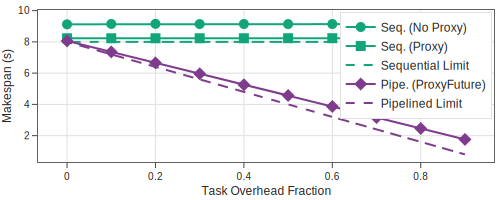

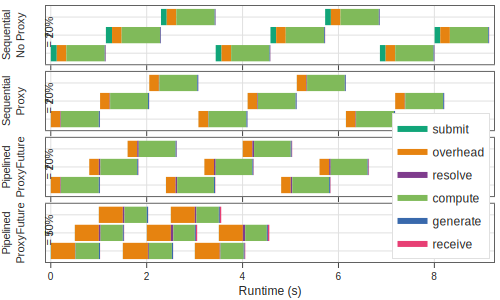

In [90]:
data = load_data(
    '../data/alderaan/0-task-pipelining/task-pipelining-2024-03-12-21-21-28',
)

trend_fig = create_trend_figure(data, dict(width=500, height=200))
timeline_fig = create_timeline_figure(data, dict(width=500, height=300))

trend_fig.show(renderer='svg')
timeline_fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/alderaan/')
figure_dir.mkdir(exist_ok=True)

trend_fig.write_image(figure_dir / '0-task-pipelining-trend.pdf')
timeline_fig.write_image(figure_dir / '0-task-pipelining-timeline.pdf')

## Polaris

Seq. No Proxy Avg. Makespan: 9.4503551801
Seq. Proxy Avg Makespan: 8.310036620400002
Improvement: 12.03%
shape: (3, 5)
┌──────────────────────┬──────────────────────┬───────┬──────────────────────┬─────────────────────┐
│ submission_method    ┆ task_overhead_fracti ┆ limit ┆ workflow_makespan_s_ ┆ workflow_makespan_s │
│ ---                  ┆ on                   ┆ ---   ┆ mean                 ┆ _std                │
│ str                  ┆ ---                  ┆ f64   ┆ ---                  ┆ ---                 │
│                      ┆ f64                  ┆       ┆ f64                  ┆ f64                 │
╞══════════════════════╪══════════════════════╪═══════╪══════════════════════╪═════════════════════╡
│ pipelined-proxy-futu ┆ 0.2                  ┆ 6.4   ┆ 6.68676              ┆ 0.001556            │
│ re                   ┆                      ┆       ┆                      ┆                     │
│ sequential-no-proxy  ┆ 0.2                  ┆ 8.0   ┆ 9.450319         

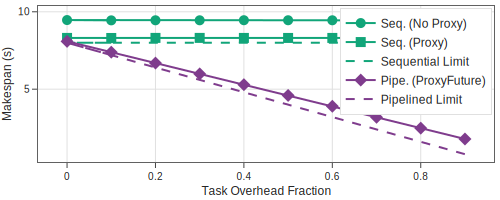

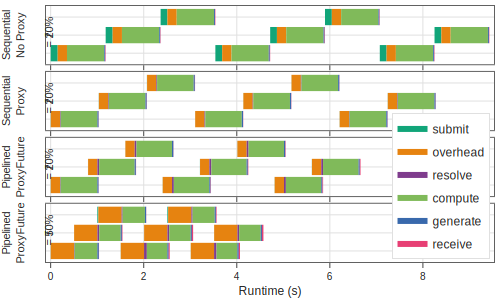

In [92]:
data = load_data(
    '../data/polaris/0-task-pipelining/task-pipelining-2024-03-13-01-45-41',
)

print_stats(data)

trend_fig = create_trend_figure(data, dict(width=500, height=200))
timeline_fig = create_timeline_figure(data, dict(width=500, height=300))

trend_fig.show(renderer='svg')
timeline_fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/polaris/')
figure_dir.mkdir(exist_ok=True)

trend_fig.write_image(figure_dir / '0-task-pipelining-trend.pdf')
timeline_fig.write_image(figure_dir / '0-task-pipelining-timeline.pdf')